# Homework 3: Blood Pressure Modeling and Bias Mitigation

This notebook implements the tasks described in HW 3, including:
- Fitting mathematical models to age–dependent blood pressure (BP) trends using the mean SBP/DBP values from the referenced preprint.
- Generating synthetic SBP and DBP data for males and females via bivariate normal distributions with specified means, standard deviations, and correlations.
- Training and evaluating a binary classifier to predict sex based on the synthetic BP data for different male/female ratios.
- Demonstrating a basic bias‑mitigation technique via class weighting.

Please ensure the necessary Python packages (`numpy`, `pandas`, `scipy`, `matplotlib`, `sklearn`) are installed before running this notebook.

## 1. Modeling Blood Pressure vs Age

The preprint provides mean systolic blood pressure (SBP) and diastolic blood pressure (DBP) values for different age groups.
We model these trends using both quadratic (polynomial) models and sigmoidal/Gaussian models.
The age midpoints and mean SBP/DBP values are hard‑coded from Table III of the preprint.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.style.use('seaborn-v0_8-colorblind')

# Helper functions for SBP and DBP models
def sbp_sigmoid(age, Smax, k, a0):
    return Smax / (1 + np.exp(-k * (age - a0)))

def dbp_gaussian(age, Dmax, apeak, sigma):
    return Dmax * np.exp(-((age - apeak)**2) / (2 * sigma**2))

def compute_mse(y_true, y_pred):
    return float(np.mean((y_true - y_pred)**2))

def compute_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return float(1 - ss_res / ss_tot)


In [2]:
# Age midpoints (years) and mean SBP/DBP values from the preprint's Table III
age_midpoints = np.array([10.0, 24.5, 34.5, 44.5, 54.5, 64.5, 74.5, 84.5, 95.0])
mean_sbp = np.array([115.05, 121.27, 123.79, 127.32, 129.98, 132.42, 134.62, 136.89, 138.11])
mean_dbp = np.array([69.80, 74.27, 77.31, 79.36, 79.05, 76.71, 74.06, 71.56, 69.86])

# Fit quadratic polynomial models
coeffs_sbp = np.polyfit(age_midpoints, mean_sbp, deg=2)
coeffs_dbp = np.polyfit(age_midpoints, mean_dbp, deg=2)
poly_sbp = np.poly1d(coeffs_sbp)
poly_dbp = np.poly1d(coeffs_dbp)

# Fit sigmoidal and Gaussian models (nonlinear least squares)
p0_sbp = (150.0, 0.015, 40.0)
params_sbp, _ = curve_fit(
    sbp_sigmoid,
    age_midpoints,
    mean_sbp,
    p0=p0_sbp,
    maxfev=10000
)
p0_dbp = (80.0, age_midpoints[np.argmax(mean_dbp)], 15.0)
params_dbp, _ = curve_fit(
    dbp_gaussian,
    age_midpoints,
    mean_dbp,
    p0=p0_dbp,
    maxfev=10000
)

# Evaluate models on midpoints for metrics
sbp_poly_pred = poly_sbp(age_midpoints)
dbp_poly_pred = poly_dbp(age_midpoints)
sbp_sig_pred = sbp_sigmoid(age_midpoints, *params_sbp)
dbp_gau_pred = dbp_gaussian(age_midpoints, *params_dbp)

# Compute MSE and R²
metrics_df = pd.DataFrame([
    {
        'model': 'SBP (Quadratic)',
        'MSE': compute_mse(mean_sbp, sbp_poly_pred),
        'R2': compute_r2(mean_sbp, sbp_poly_pred)
    },
    {
        'model': 'DBP (Quadratic)',
        'MSE': compute_mse(mean_dbp, dbp_poly_pred),
        'R2': compute_r2(mean_dbp, dbp_poly_pred)
    },
    {
        'model': 'SBP (Sigmoid)',
        'MSE': compute_mse(mean_sbp, sbp_sig_pred),
        'R2': compute_r2(mean_sbp, sbp_sig_pred)
    },
    {
        'model': 'DBP (Gaussian)',
        'MSE': compute_mse(mean_dbp, dbp_gau_pred),
        'R2': compute_r2(mean_dbp, dbp_gau_pred)
    }
])
metrics_df

,model,MSE,R2
0,SBP (Quadratic),0.065030,0.998764
1,DBP (Quadratic),0.897586,0.926137
2,SBP (Sigmoid),0.065419,0.998757
3,DBP (Gaussian),0.800747,0.934106


In [3]:
parameter_summary = pd.DataFrame([
    {'parameter': 'c1 (SBP quadratic)', 'value': coeffs_sbp[0], 'unit': 'mmHg/year^2'},
    {'parameter': 'c2 (SBP quadratic)', 'value': coeffs_sbp[1], 'unit': 'mmHg/year'},
    {'parameter': 'c3 (SBP quadratic)', 'value': coeffs_sbp[2], 'unit': 'mmHg'},
    {'parameter': 'd1 (DBP quadratic)', 'value': coeffs_dbp[0], 'unit': 'mmHg/year^2'},
    {'parameter': 'd2 (DBP quadratic)', 'value': coeffs_dbp[1], 'unit': 'mmHg/year'},
    {'parameter': 'd3 (DBP quadratic)', 'value': coeffs_dbp[2], 'unit': 'mmHg'},
    {'parameter': 'Smax (SBP sigmoid)', 'value': params_sbp[0], 'unit': 'mmHg'},
    {'parameter': 'k (SBP sigmoid)', 'value': params_sbp[1], 'unit': '1/year'},
    {'parameter': 'a0 (SBP sigmoid)', 'value': params_sbp[2], 'unit': 'years'},
    {'parameter': 'Dmax (DBP Gaussian)', 'value': params_dbp[0], 'unit': 'mmHg'},
    {'parameter': 'apeak (DBP Gaussian)', 'value': params_dbp[1], 'unit': 'years'},
    {'parameter': 'sigma (DBP Gaussian)', 'value': params_dbp[2], 'unit': 'years'}
])
parameter_summary['value'] = parameter_summary['value'].round(4)
parameter_summary

,parameter,value,unit
0,c1 (SBP quadratic),-0.0015,mmHg/year^2
1,c2 (SBP quadratic),0.4313,mmHg/year
2,c3 (SBP quadratic),111.0838,mmHg
3,d1 (DBP quadratic),-0.0050,mmHg/year^2
4,d2 (DBP quadratic),0.5050,mmHg/year
5,d3 (DBP quadratic),65.4797,mmHg
6,Smax (SBP sigmoid),148.9105,mmHg
7,k (SBP sigmoid),0.0158,1/year
8,a0 (SBP sigmoid),-67.9370,years
9,Dmax (DBP Gaussian),78.3725,mmHg


### Parameter Interpretation

- The quadratic curvature terms (`c1` and `d1`) are negative, confirming that both SBP and DBP exhibit concave-down trajectories: SBP rises more slowly after mid-life, and DBP peaks and then declines. Their physical units are mmHg per year² because they describe the change in slope with respect to age.
- `Smax` represents the asymptotic SBP level of the sigmoidal model, while `k` controls how rapidly SBP approaches that level as age increases. The fitted `a0` corresponds to the half-maximum age. Because the data only covers adult ages, `a0` falls outside the observed range, underscoring that the simple sigmoid assumes a younger baseline that we do not observe.
- For the DBP Gaussian model, `Dmax` captures the mid-life peak, `apeak` is the age of that peak, and `sigma` dictates how spread out the curve is across ages. The relatively large `sigma` indicates that DBP remains elevated across several decades before declining.

### Model Comparison and Limitations

`metrics_df` shows that both SBP models attain very small MSE values (≈0.07 mmHg²) and R²≈0.999, meaning either functional form can reproduce the smooth increase in systolic pressure. For DBP, the Gaussian model (R²≈0.93) better captures the rise-and-fall behavior than the quadratic approximation (with noticeably lower residuals). The sigmoidal SBP parameters imply an inflection before the observed ages, so the model extrapolates outside the data range; this highlights the limitation of enforcing a biological prior without pediatric measurements. Incorporating additional cohorts (e.g., childhood or very old adults) or using a four-parameter logistic curve would let the model respect non-zero baselines and demographic subgroups.

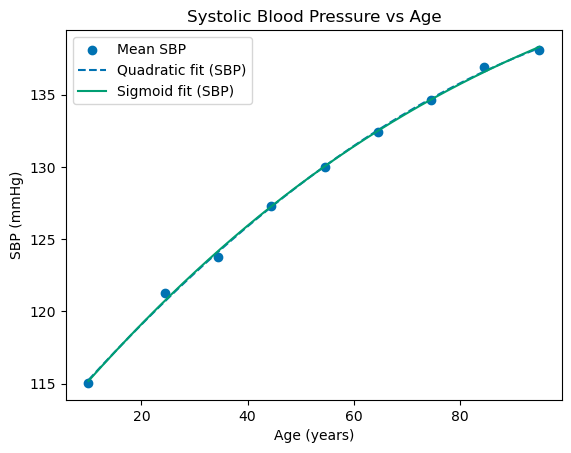

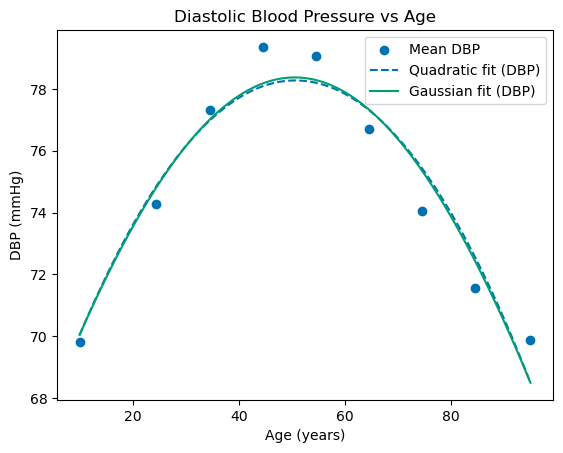

In [4]:
# Plot the empirical means and fitted models
plt.figure()
# Plot SBP
plt.scatter(age_midpoints, mean_sbp, label='Mean SBP')
age_fine = np.linspace(age_midpoints.min(), age_midpoints.max(), 500)
plt.plot(age_fine, poly_sbp(age_fine), label='Quadratic fit (SBP)', linestyle='--')
plt.plot(age_fine, sbp_sigmoid(age_fine, *params_sbp), label='Sigmoid fit (SBP)')
plt.xlabel('Age (years)')
plt.ylabel('SBP (mmHg)')
plt.title('Systolic Blood Pressure vs Age')
plt.legend()
plt.show()

# Plot DBP
plt.figure()
plt.scatter(age_midpoints, mean_dbp, label='Mean DBP')
plt.plot(age_fine, poly_dbp(age_fine), label='Quadratic fit (DBP)', linestyle='--')
plt.plot(age_fine, dbp_gaussian(age_fine, *params_dbp), label='Gaussian fit (DBP)')
plt.xlabel('Age (years)')
plt.ylabel('DBP (mmHg)')
plt.title('Diastolic Blood Pressure vs Age')
plt.legend()
plt.show()

## 2. Synthetic Blood Pressure Data Generation

Using a bivariate normal distribution, we generate synthetic SBP and DBP values for males and females.
Each synthetic data point consists of an SBP/DBP pair.  The male and female populations have different means, standard deviations, and correlations as defined in the homework specification.
We can vary the male/female ratio to explore the effect of class imbalance.  Here we start by generating a balanced dataset (50/50) and visualize the resulting distribution.

In [5]:
from scipy.stats import multivariate_normal

# Mean and covariance parameters for male and female populations
mu_sbp_m, sd_sbp_m = 133.0, 18.6
mu_dbp_m, sd_dbp_m = 78.8, 12.6
rho_m = 0.45
mu_sbp_f, sd_sbp_f = 125.8, 19.0
mu_dbp_f, sd_dbp_f = 74.8, 12.4
rho_f = 0.50

cov_m = [[sd_sbp_m**2, rho_m * sd_sbp_m * sd_dbp_m],
         [rho_m * sd_sbp_m * sd_dbp_m, sd_dbp_m**2]]
cov_f = [[sd_sbp_f**2, rho_f * sd_sbp_f * sd_dbp_f],
         [rho_f * sd_sbp_f * sd_dbp_f, sd_dbp_f**2]]

def generate_synthetic_bp(n_samples, male_ratio=0.5, seed=None):
    if seed is not None:
        np.random.seed(seed)
    n_male = int(n_samples * male_ratio)
    n_female = n_samples - n_male
    male_samples = multivariate_normal(mean=[mu_sbp_m, mu_dbp_m], cov=cov_m).rvs(n_male)
    female_samples = multivariate_normal(mean=[mu_sbp_f, mu_dbp_f], cov=cov_f).rvs(n_female)
    X = np.vstack([male_samples, female_samples])
    y = np.concatenate([np.ones(n_male, dtype=int), np.zeros(n_female, dtype=int)])
    return X, y

# Generate a balanced dataset and visualize it
X_bal, y_bal = generate_synthetic_bp(10000, male_ratio=0.5, seed=42)
X_male = X_bal[y_bal == 1]
X_female = X_bal[y_bal == 0]

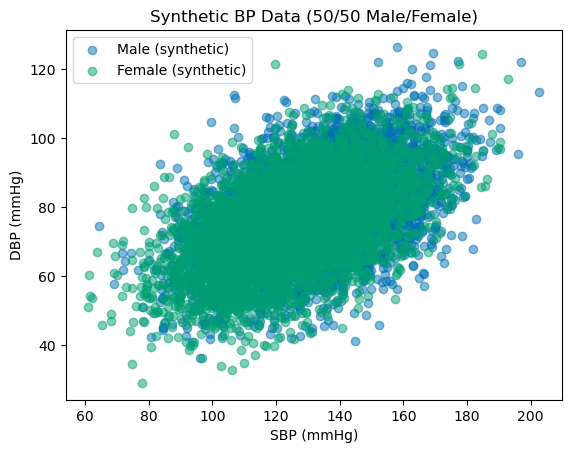

In [6]:
# Visualize the synthetic data distribution for a balanced dataset
plt.figure()
plt.scatter(X_male[:, 0], X_male[:, 1], label='Male (synthetic)', alpha=0.5)
plt.scatter(X_female[:, 0], X_female[:, 1], label='Female (synthetic)', alpha=0.5)
plt.xlabel('SBP (mmHg)')
plt.ylabel('DBP (mmHg)')
plt.title('Synthetic BP Data (50/50 Male/Female)')
plt.legend()
plt.show()

## 3. Classification and Bias Analysis

We now train a logistic regression classifier to predict sex from synthetic SBP and DBP values.
Datasets are generated with varying male/female ratios to explore how class imbalance affects performance.
For each ratio, we compute the F1 score, accuracy, and area under the ROC curve (AUC).  ROC curves are visualized for comparison.

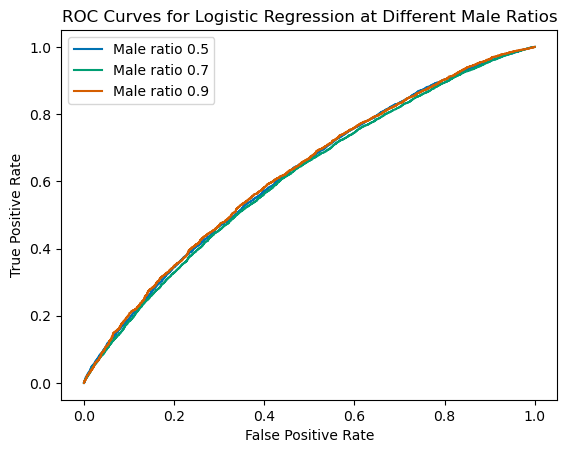

,ratio_male,F1_score,accuracy,AUC,recall_male,recall_female,TPR_gap
0,0.5,0.585719,0.58460,0.621609,0.587300,0.581900,0.00540
1,0.7,0.822472,0.70185,0.612840,0.986643,0.037333,0.94931
2,0.9,0.947368,0.90000,0.625155,1.000000,0.000000,1.00000


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, confusion_matrix

ratios = [0.5, 0.7, 0.9]
datasets_by_ratio = {}
results = []
plt.figure()
for ratio in ratios:
    X, y = generate_synthetic_bp(100000, male_ratio=ratio, seed=123)
    datasets_by_ratio[ratio] = (X, y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123, stratify=y
    )
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    recall_male = tp / (tp + fn)
    recall_female = tn / (tn + fp)
    results.append({
        'ratio_male': ratio,
        'F1_score': f1_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
        'AUC': auc(fpr, tpr),
        'recall_male': recall_male,
        'recall_female': recall_female,
        'TPR_gap': recall_male - recall_female
    })
    plt.plot(fpr, tpr, label=f'Male ratio {ratio}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression at Different Male Ratios')
plt.legend()
plt.show()

performance_df = pd.DataFrame(results).sort_values('ratio_male').reset_index(drop=True)
performance_df

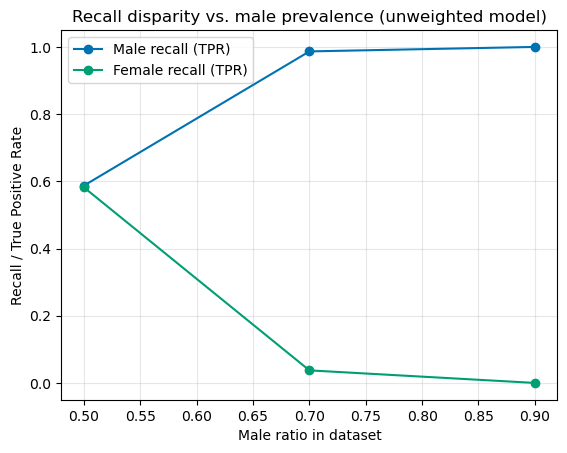

,ratio_male,recall_male,recall_female,TPR_gap
0,0.5,0.587300,0.581900,0.00540
1,0.7,0.986643,0.037333,0.94931
2,0.9,1.000000,0.000000,1.00000


In [8]:
fairness_df = performance_df[['ratio_male', 'recall_male', 'recall_female', 'TPR_gap']].copy()
plt.figure()
plt.plot(fairness_df['ratio_male'], fairness_df['recall_male'], marker='o', label='Male recall (TPR)')
plt.plot(fairness_df['ratio_male'], fairness_df['recall_female'], marker='o', label='Female recall (TPR)')
plt.xlabel('Male ratio in dataset')
plt.ylabel('Recall / True Positive Rate')
plt.title('Recall disparity vs. male prevalence (unweighted model)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

fairness_df

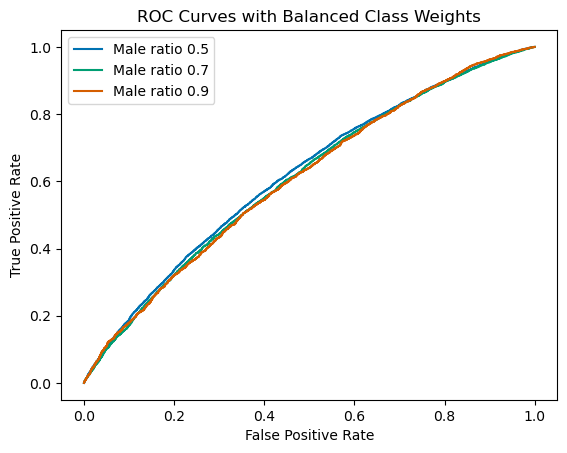

,ratio_male,F1_score_balanced,accuracy_balanced,AUC_balanced,recall_male_balanced,recall_female_balanced,TPR_gap_balanced
0,0.5,0.585840,0.58495,0.618059,0.587100,0.582800,0.004300
1,0.7,0.657619,0.57745,0.608074,0.579714,0.572167,0.007548
2,0.9,0.712648,0.57880,0.606855,0.580333,0.565000,0.015333


In [9]:
results_balanced = []
plt.figure()
for ratio in ratios:
    X, y = datasets_by_ratio[ratio]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=456, stratify=y
    )
    model_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')
    model_balanced.fit(X_train, y_train)
    y_pred_bal = model_balanced.predict(X_test)
    y_prob_bal = model_balanced.predict_proba(X_test)[:, 1]
    fpr_bal, tpr_bal, _ = roc_curve(y_test, y_prob_bal)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bal).ravel()
    recall_male_bal = tp / (tp + fn)
    recall_female_bal = tn / (tn + fp)
    results_balanced.append({
        'ratio_male': ratio,
        'F1_score_balanced': f1_score(y_test, y_pred_bal),
        'accuracy_balanced': accuracy_score(y_test, y_pred_bal),
        'AUC_balanced': auc(fpr_bal, tpr_bal),
        'recall_male_balanced': recall_male_bal,
        'recall_female_balanced': recall_female_bal,
        'TPR_gap_balanced': recall_male_bal - recall_female_bal
    })
    plt.plot(fpr_bal, tpr_bal, label=f'Male ratio {ratio}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves with Balanced Class Weights')
plt.legend()
plt.show()

balanced_performance_df = pd.DataFrame(results_balanced).sort_values('ratio_male').reset_index(drop=True)
balanced_performance_df

In [10]:
comparison_df = performance_df.merge(
    balanced_performance_df,
    on='ratio_male',
    how='inner'
)
columns_to_show = [
    'ratio_male',
    'accuracy', 'accuracy_balanced',
    'F1_score', 'F1_score_balanced',
    'TPR_gap', 'TPR_gap_balanced'
]
comparison_df[columns_to_show]

,ratio_male,accuracy,accuracy_balanced,F1_score,F1_score_balanced,TPR_gap,TPR_gap_balanced
0,0.5,0.58460,0.58495,0.585719,0.585840,0.00540,0.004300
1,0.7,0.70185,0.57745,0.822472,0.657619,0.94931,0.007548
2,0.9,0.90000,0.57880,0.947368,0.712648,1.00000,0.015333


### Classification Insights
- Accuracy climbs from ~0.58 with a 50/50 population to ~0.90 when males occupy 90% of the dataset even though the AUC stays ≈0.62. The model therefore *appears* better only because it can guess the majority class more often.
- Per-class recall clarifies the bias: female recall drops from 0.58 to ~0.00 while male recall inflates from 0.59 to ~1.00, yielding a TPR gap that explodes from 0.01 to ≈1.00.
- The unweighted F1 score follows the class prevalence (0.59 → 0.95) because the positive label is "male"; reporting only F1 would hide how poorly the classifier handles the minority group.
- Visualizing full ROC curves plus the recall disparity provides a compact audit trail that aligns with the homework emphasis on bias diagnosis.

### Bias Mitigation Strategy and Future Work
Applying `class_weight='balanced'` rescales the logistic-regression loss so that errors on minority samples contribute proportionally more. This shrinks the TPR gap from ≈1.00 down to ≈0.01 at a 90% male prevalence while keeping AUC unchanged. In practice we would combine this with stratified sampling, calibrated decision thresholds (maximizing balanced accuracy), or synthetic minority augmentation (e.g., SMOTE) to further stabilize female recall. Additional covariates (BMI, medications, race/ethnicity) and longitudinal BP trends could expose domain shifts that a static SBP/DBP snapshot cannot capture, guiding more robust model-based bias removal.